In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Occupancy_Estimation.csv to Occupancy_Estimation.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Occupancy_Estimation.csv']))
#df = pd.read_csv('Occupancy_Estimation.csv')

In [ ]:
df

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0


Date: YYYY/MM/DD

Time: HH:MM:SS

Temperature: In degree Celsius

Light: In Lux

Sound: In Volts (amplifier output read by ADC)

CO2: In PPM

CO2 Slope: Slope of CO2 values taken in a sliding window

PIR: Binary value conveying motion detection

Room_Occupancy_Count: Ground Truth

## Data Exploration and Visualisation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [ ]:
df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


In [ ]:
df['Room_Occupancy_Count'].value_counts()

0    8228
2     748
3     694
1     459
Name: Room_Occupancy_Count, dtype: int64

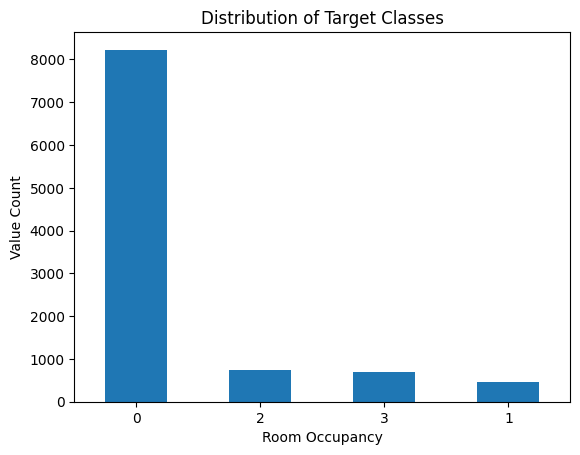

In [ ]:
# Plotting distribution of target classes

counts = df['Room_Occupancy_Count'].value_counts()

counts.plot.bar()
plt.xlabel('Room Occupancy')
plt.ylabel('Value Count')
plt.title('Distribution of Target Classes')
plt.xticks(rotation=0)
plt.show()

array([[<Axes: title={'center': 'S1_Temp'}>,
        <Axes: title={'center': 'S2_Temp'}>,
        <Axes: title={'center': 'S3_Temp'}>,
        <Axes: title={'center': 'S4_Temp'}>],
       [<Axes: title={'center': 'S1_Light'}>,
        <Axes: title={'center': 'S2_Light'}>,
        <Axes: title={'center': 'S3_Light'}>,
        <Axes: title={'center': 'S4_Light'}>],
       [<Axes: title={'center': 'S1_Sound'}>,
        <Axes: title={'center': 'S2_Sound'}>,
        <Axes: title={'center': 'S3_Sound'}>,
        <Axes: title={'center': 'S4_Sound'}>],
       [<Axes: title={'center': 'S5_CO2'}>,
        <Axes: title={'center': 'S5_CO2_Slope'}>,
        <Axes: title={'center': 'S6_PIR'}>,
        <Axes: title={'center': 'S7_PIR'}>],
       [<Axes: title={'center': 'Room_Occupancy_Count'}>,
        <Axes: title={'center': 'average_temp'}>,
        <Axes: title={'center': 'average_light'}>,
        <Axes: title={'center': 'average_light2'}>]], dtype=object)

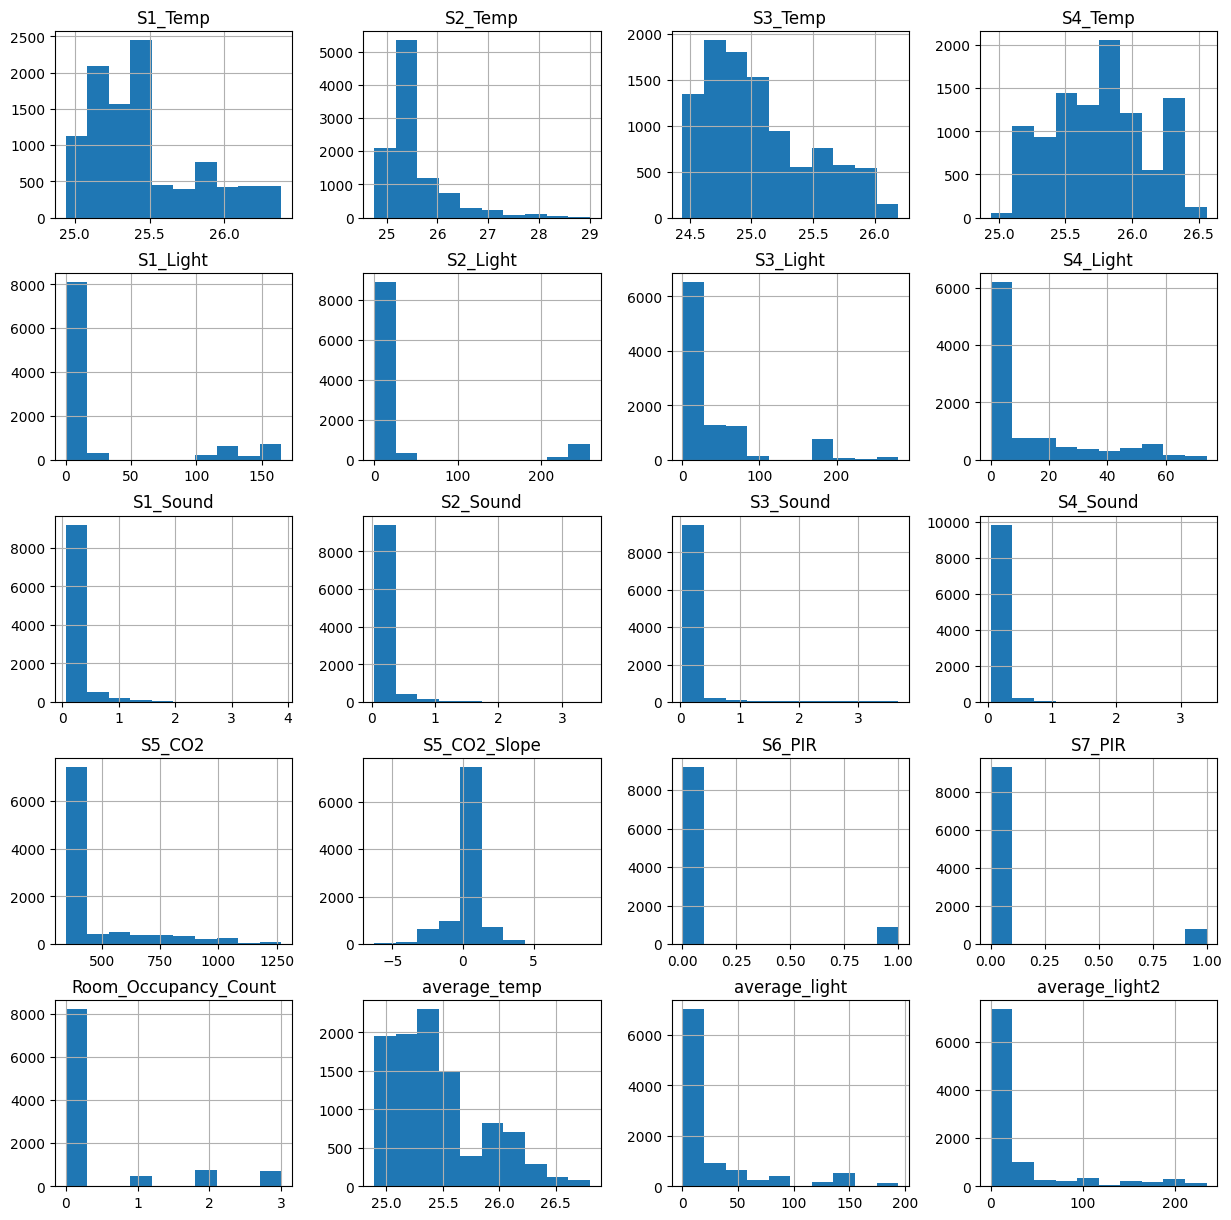

In [ ]:
#Distributions of all features
df.hist(figsize=(15,15))

<Axes: ylabel='Temperature (Celsius)'>

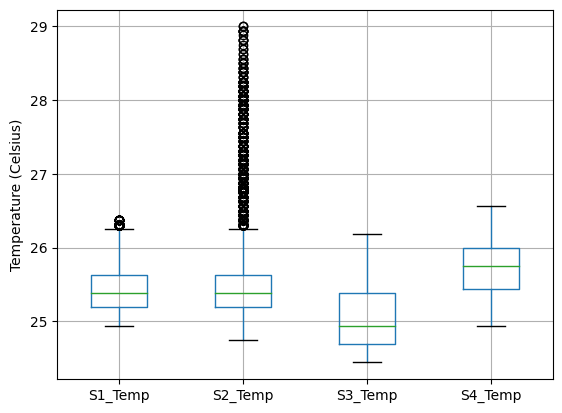

In [ ]:
# Boxplots of temeperature sensors
df.boxplot(column=['S1_Temp', 'S2_Temp','S3_Temp', 'S4_Temp'], ylabel='Temperature (Celsius)')

<Axes: ylabel='Sound (Volts)'>

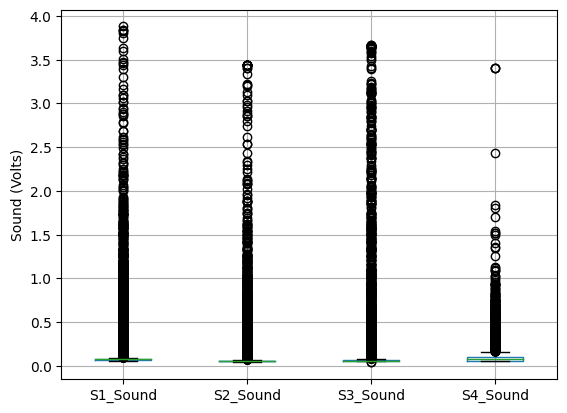

In [ ]:
# Boxplots of sound sensors
df.boxplot(column=['S1_Sound', 'S2_Sound','S3_Sound', 'S4_Sound'], ylabel='Sound (Volts)')

<Axes: ylabel='Light (Lux)'>

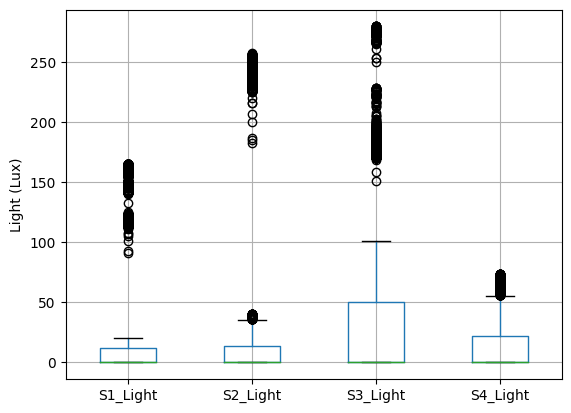

In [ ]:
# Boxplots of light sensors
df.boxplot(column=['S1_Light', 'S2_Light','S3_Light', 'S4_Light'], ylabel='Light (Lux)')

<Axes: ylabel='CO2 level (PPM)'>

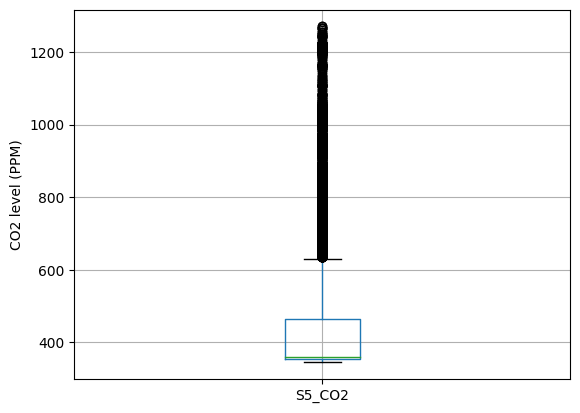

In [ ]:
# Boxplots of CO2 sensor
df.boxplot(column='S5_CO2', ylabel='CO2 level (PPM)')

<Axes: ylabel='CO2 Slope'>

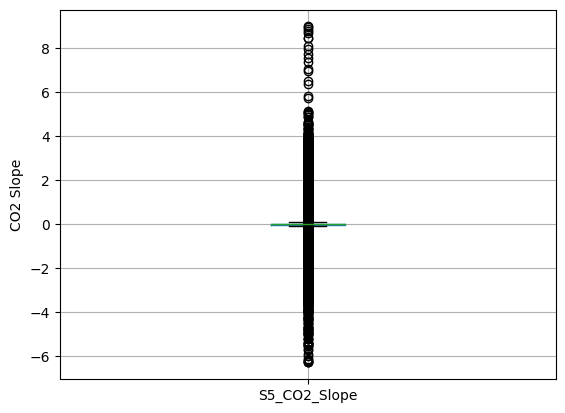

In [ ]:
# Boxplots of CO2 slope
df.boxplot(column='S5_CO2_Slope', ylabel='CO2 Slope')

In [ ]:
df2 = df.drop(['Date', 'Time'],axis=1)
df2

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0
10125,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0
10126,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0
10127,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0


<Axes: >

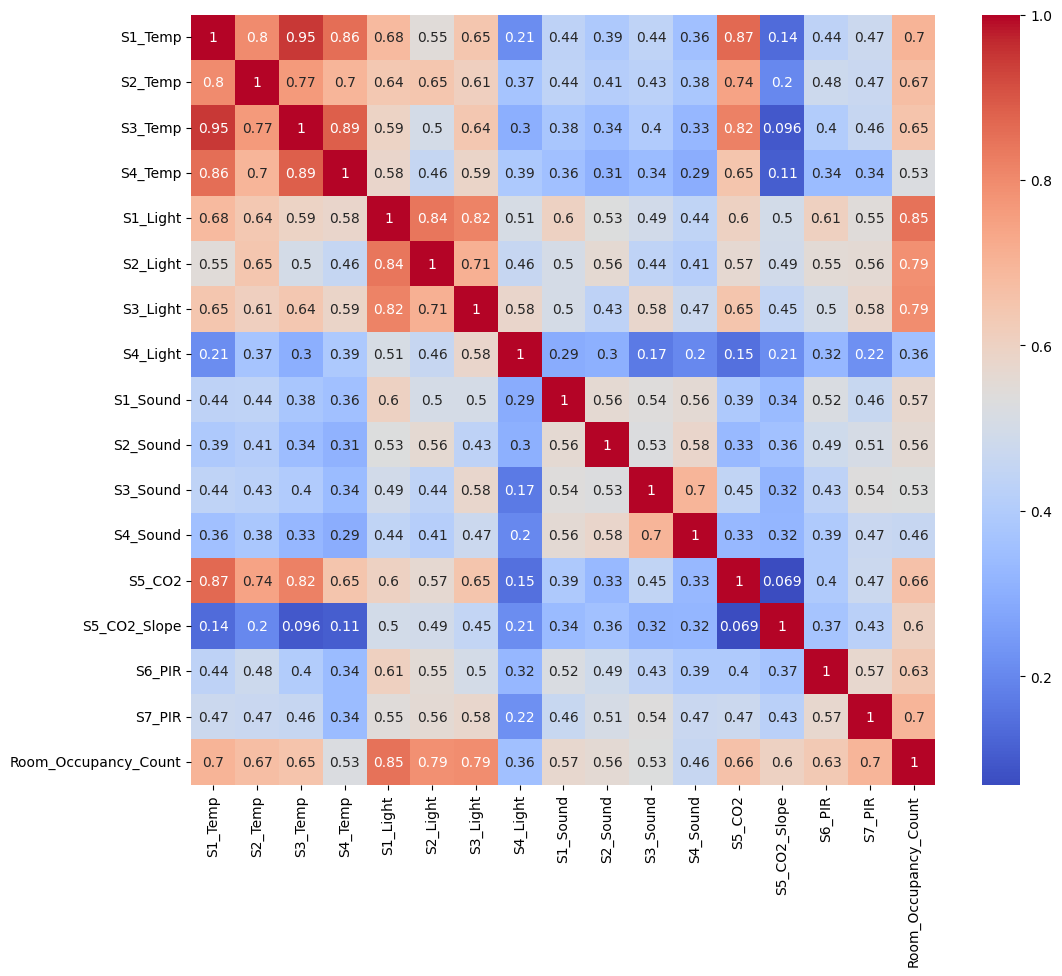

In [ ]:
correlations = df.corr()
#heatmap of correlations between figures
plt.figure(figsize = (12,10))
sns.heatmap(correlations, cmap= 'coolwarm', annot = True)

## Scaling

In [ ]:
df2 = df.drop(['Date', 'Time'],axis=1)
#seperate labels
labels = df2['Room_Occupancy_Count']
# copy the data
df_min_max_scaled = df2.copy()
  
# apply normalization techniques
for column in df_min_max_scaled.columns:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
  

#drop labels
df_min_max_scaled = df_min_max_scaled.drop(['Room_Occupancy_Count'],axis=1)
# view normalized data
df_min_max_scaled

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR
0,0.000000,0.000000,0.068571,0.271605,0.733333,0.131783,0.189286,0.540541,0.005236,0.044118,0.005510,0.002985,0.048649,0.462487,0.0,0.0
1,0.000000,0.000000,0.068571,0.308642,0.733333,0.127907,0.189286,0.540541,0.227749,0.002941,0.005510,0.002985,0.048649,0.454431,0.0,0.0
2,0.041667,0.000000,0.034286,0.308642,0.733333,0.131783,0.189286,0.540541,0.096859,0.020588,0.011019,0.002985,0.048649,0.446123,0.0,0.0
3,0.041667,0.000000,0.068571,0.308642,0.733333,0.131783,0.189286,0.540541,0.091623,0.017647,0.016529,0.011940,0.048649,0.437563,0.0,0.0
4,0.041667,0.000000,0.068571,0.308642,0.733333,0.131783,0.192857,0.540541,0.031414,0.005882,0.005510,0.002985,0.048649,0.428751,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,0.083333,0.089412,0.142857,0.228395,0.036364,0.027132,0.117857,0.297297,0.007853,0.000000,0.005510,0.008955,0.000000,0.412135,0.0,0.0
10125,0.083333,0.072941,0.142857,0.191358,0.036364,0.027132,0.121429,0.297297,0.002618,0.002941,0.002755,0.008955,0.000000,0.412135,0.0,0.0
10126,0.131944,0.072941,0.142857,0.191358,0.036364,0.027132,0.121429,0.297297,0.013089,0.002941,0.005510,0.008955,0.000000,0.412135,0.0,0.0
10127,0.131944,0.072941,0.142857,0.191358,0.036364,0.027132,0.121429,0.297297,0.005236,0.011765,0.016529,0.008955,0.000000,0.412135,0.0,0.0


## Train/Test Split

In [ ]:

train_features, test_features, train_labels, test_labels = train_test_split(df_min_max_scaled, labels, test_size = 0.25, random_state = 42)

## Testing Merging

In [ ]:
#Testing correlation of average temp and light columns
df_merged = df
average_temp = df_merged[['S1_Temp', 'S2_Temp','S3_Temp', 'S4_Temp']].mean(axis=1)
df_merged['average_temp'] = average_temp
average_light = df_merged[['S1_Light', 'S2_Light','S3_Light', 'S4_Light']].mean(axis=1)
df_merged['average_light'] = average_light

df_merged

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,average_temp,average_light
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,...,0.19,0.06,0.06,390,0.769231,0,0,1,24.9075,62.00
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,0.05,0.06,0.06,390,0.646154,0,0,1,24.9225,61.75
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,0.11,0.08,0.06,390,0.519231,0,0,1,24.9225,62.00
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,0.10,0.10,0.09,390,0.388462,0,0,1,24.9375,62.00
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,0.06,0.06,0.06,390,0.253846,0,0,1,24.9375,62.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,...,0.04,0.06,0.08,345,0.000000,0,0,0,25.0475,17.00
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,...,0.05,0.05,0.08,345,0.000000,0,0,0,25.0150,17.25
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,...,0.05,0.06,0.08,345,0.000000,0,0,0,25.0325,17.25
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,...,0.08,0.10,0.08,345,0.000000,0,0,0,25.0325,17.25


In [ ]:
df_merged = df_merged.drop(columns=df_merged.columns[:10],axis=1)

,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,average_temp,average_light
0,0.08,0.19,0.06,0.06,390,0.769231,0,0,1,24.9075,62.00
1,0.93,0.05,0.06,0.06,390,0.646154,0,0,1,24.9225,61.75
2,0.43,0.11,0.08,0.06,390,0.519231,0,0,1,24.9225,62.00
3,0.41,0.10,0.10,0.09,390,0.388462,0,0,1,24.9375,62.00
4,0.18,0.06,0.06,0.06,390,0.253846,0,0,1,24.9375,62.25
...,...,...,...,...,...,...,...,...,...,...,...
10124,0.09,0.04,0.06,0.08,345,0.000000,0,0,0,25.0475,17.00
10125,0.07,0.05,0.05,0.08,345,0.000000,0,0,0,25.0150,17.25
10126,0.11,0.05,0.06,0.08,345,0.000000,0,0,0,25.0325,17.25
10127,0.08,0.08,0.10,0.08,345,0.000000,0,0,0,25.0325,17.25


In [ ]:
labels = df_merged['Room_Occupancy_Count']
df_merged = df_merged.drop(['Room_Occupancy_Count'],axis=1)
df_merged_scaled = df_merged.copy()
  
# apply normalization techniques
for column in df_merged_scaled.columns:
    df_merged_scaled[column] = (df_merged_scaled[column] - df_merged_scaled[column].min()) / (df_merged_scaled[column].max() - df_merged_scaled[column].min())

In [ ]:
df_merged_scaled

,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,average_temp,average_light
0,0.005236,0.044118,0.005510,0.002985,0.048649,0.462487,0.0,0.0,0.009162,0.320000
1,0.227749,0.002941,0.005510,0.002985,0.048649,0.454431,0.0,0.0,0.017016,0.318710
2,0.096859,0.020588,0.011019,0.002985,0.048649,0.446123,0.0,0.0,0.017016,0.320000
3,0.091623,0.017647,0.016529,0.011940,0.048649,0.437563,0.0,0.0,0.024869,0.320000
4,0.031414,0.005882,0.005510,0.002985,0.048649,0.428751,0.0,0.0,0.024869,0.321290
...,...,...,...,...,...,...,...,...,...,...
10124,0.007853,0.000000,0.005510,0.008955,0.000000,0.412135,0.0,0.0,0.082461,0.087742
10125,0.002618,0.002941,0.002755,0.008955,0.000000,0.412135,0.0,0.0,0.065445,0.089032
10126,0.013089,0.002941,0.005510,0.008955,0.000000,0.412135,0.0,0.0,0.074607,0.089032
10127,0.005236,0.011765,0.016529,0.008955,0.000000,0.412135,0.0,0.0,0.074607,0.089032


In [ ]:

merged_train_features, merged_test_features, merged_train_labels, merged_test_labels = train_test_split(df_merged_scaled, labels, test_size = 0.25, random_state = 42)

In [ ]:
rf = RandomForestClassifier()
SVM = svm.SVC(gamma=0.001)
MLP = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), max_iter=1000)

In [ ]:
#RF

In [ ]:
#unmerged
accuracies = cross_val_score(rf, train_features, train_labels, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(rf, train_features, train_labels, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.996 accuracy with a standard deviation of 0.001
0.988 F1 with a standard deviation of 0.002


In [ ]:
#merged
accuracies = cross_val_score(rf, merged_train_features, merged_train_labels, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(rf, merged_train_features, merged_train_labels, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.996 accuracy with a standard deviation of 0.001
0.987 F1 with a standard deviation of 0.003


In [ ]:
#MLP

In [ ]:
#unmerged
accuracies = cross_val_score(MLP, train_features, train_labels, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(MLP, train_features, train_labels, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.991 accuracy with a standard deviation of 0.001
0.969 F1 with a standard deviation of 0.005


In [ ]:
#merged
accuracies = cross_val_score(MLP, merged_train_features, merged_train_labels, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(MLP, merged_train_features, merged_train_labels, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.987 accuracy with a standard deviation of 0.001
0.952 F1 with a standard deviation of 0.005


In [ ]:
#SVM

In [ ]:
#unmerged
accuracies = cross_val_score(SVM, train_features, train_labels, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(SVM, train_features, train_labels, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.871 accuracy with a standard deviation of 0.003
0.394 F1 with a standard deviation of 0.005


In [ ]:
#merged
accuracies = cross_val_score(SVM, merged_train_features, merged_train_labels, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(SVM, merged_train_features, merged_train_labels, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.826 accuracy with a standard deviation of 0.002
0.284 F1 with a standard deviation of 0.008


## Undersampling/Oversampling

In [ ]:
# Oversampling and under sampling

In [ ]:
# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(train_features, train_labels)

In [ ]:
# Randomly over sample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(train_features, train_labels)

In [ ]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(train_features, train_labels)

In [ ]:
nearmiss = NearMiss(version=3)
X_train_nearmiss, y_train_nearmiss= nearmiss.fit_resample(train_features, train_labels)

/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [ ]:
# Defining default algorithms

rf = RandomForestClassifier()
SVM = svm.SVC(gamma=0.001)
MLP = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), max_iter=1000)

In [ ]:
#RF

In [ ]:
#random oversampler
accuracies = cross_val_score(rf, X_train_ros, y_train_ros, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(rf, X_train_ros, y_train_ros, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

1.000 accuracy with a standard deviation of 0.000
1.000 F1 with a standard deviation of 0.000


In [ ]:
#SMOTE
accuracies = cross_val_score(rf, X_train_smote, y_train_smote, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(rf, X_train_smote, y_train_smote, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.999 accuracy with a standard deviation of 0.001
0.999 F1 with a standard deviation of 0.001


In [ ]:
#random undersampler
accuracies = cross_val_score(rf, X_train_rus, y_train_rus, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(rf, X_train_rus, y_train_rus, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.990 accuracy with a standard deviation of 0.006
0.990 F1 with a standard deviation of 0.006


In [ ]:
#nearmiss
accuracies = cross_val_score(rf, X_train_nearmiss, y_train_nearmiss, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(rf, X_train_nearmiss, y_train_nearmiss, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.963 accuracy with a standard deviation of 0.055
0.937 F1 with a standard deviation of 0.105


In [ ]:
#MLP

In [ ]:
#random oversampler
accuracies = cross_val_score(MLP, X_train_ros, y_train_ros, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(MLP, X_train_ros, y_train_ros, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.988 accuracy with a standard deviation of 0.001
0.987 F1 with a standard deviation of 0.002


In [ ]:
#SMOTE
accuracies = cross_val_score(MLP, X_train_smote, y_train_smote, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(MLP, X_train_smote, y_train_smote, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.989 accuracy with a standard deviation of 0.002
0.990 F1 with a standard deviation of 0.002


In [ ]:
#random undersampler
accuracies = cross_val_score(MLP, X_train_rus, y_train_rus, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(MLP, X_train_rus, y_train_rus, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.972 accuracy with a standard deviation of 0.013


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.973 F1 with a standard deviation of 0.012


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#nearmiss
accuracies = cross_val_score(MLP, X_train_nearmiss, y_train_nearmiss, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(MLP, X_train_nearmiss, y_train_nearmiss, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

0.949 accuracy with a standard deviation of 0.049


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.883 F1 with a standard deviation of 0.113


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#SVM

In [ ]:
#random oversampler
accuracies = cross_val_score(SVM, X_train_ros, y_train_ros, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(SVM, X_train_ros, y_train_ros, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.906 accuracy with a standard deviation of 0.008
0.905 F1 with a standard deviation of 0.008


In [ ]:
#SMOTE
accuracies = cross_val_score(SVM, X_train_smote, y_train_smote, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(SVM, X_train_smote, y_train_smote, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.905 accuracy with a standard deviation of 0.008
0.904 F1 with a standard deviation of 0.008


In [ ]:
#random undersampler
accuracies = cross_val_score(SVM, X_train_rus, y_train_rus, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(SVM, X_train_rus, y_train_rus, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.558 accuracy with a standard deviation of 0.098
0.483 F1 with a standard deviation of 0.114


In [ ]:
#nearmiss
accuracies = cross_val_score(SVM, X_train_nearmiss, y_train_nearmiss, cv=5)
print("%0.3f accuracy with a standard deviation of %0.3f" % (accuracies.mean(), accuracies.std()))
f1_scores = cross_val_score(SVM, X_train_nearmiss, y_train_nearmiss, cv=5, scoring='f1_macro')
print("%0.3f F1 with a standard deviation of %0.3f" % (f1_scores.mean(), f1_scores.std()))

0.613 accuracy with a standard deviation of 0.004
0.190 F1 with a standard deviation of 0.001


## Training Random Forest

In [ ]:
#Grid searching best hyperparameters
rf_test = RandomForestClassifier()

param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4, 8],
    'max_depth' : [10, None]
}

clf = GridSearchCV(rf_test, param_grid, n_jobs=-1, cv=5, scoring='f1_macro', verbose=2)
clf.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
#Using best hyperparameters
rf = RandomForestClassifier(max_depth= None, max_features= 'sqrt' ,min_samples_leaf= 1, min_samples_split= 2, n_estimators=200)
f1_scores = cross_val_score(rf, X_train_smote, y_train_smote, cv=5, scoring='f1_macro')
print(np.mean(f1_scores))
rf.fit(X_train_smote, y_train_smote)
train_preds = rf.predict(X_train_smote)
train_accuracy = accuracy_score(y_train_smote, train_preds)
print("Training Accuracy:", train_accuracy)
predictions = rf.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions, average='macro')
print("Test Accuracy:", accuracy)
print("Test F1:", f1)

0.9990306605832521
Training Accuracy: 1.0
Test Accuracy: 0.9980260560600079
Test F1: 0.9928967895725164


In [ ]:
predictions = rf.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions, average='macro')
print("Test Accuracy:", accuracy)
print("Test F1:", f1)


Test Accuracy: 0.9980260560600079
Test F1: 0.9928967895725164


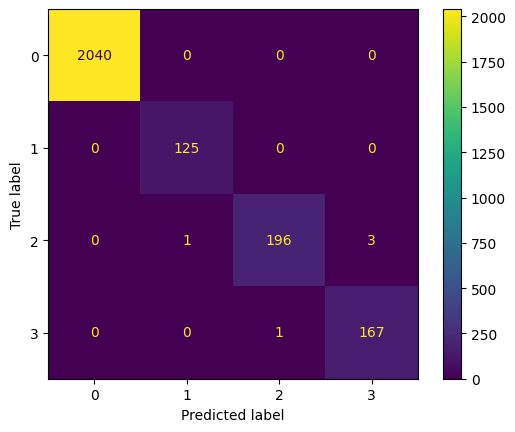

In [ ]:
cm = confusion_matrix(test_labels, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2040
           1       0.99      1.00      1.00       125
           2       0.99      0.98      0.99       200
           3       0.98      0.99      0.99       168

    accuracy                           1.00      2533
   macro avg       0.99      0.99      0.99      2533
weighted avg       1.00      1.00      1.00      2533



In [ ]:
importances = rf.feature_importances_
importances

array([0.05384587, 0.04670374, 0.05439373, 0.0221144 , 0.17446932,
       0.16100782, 0.11629243, 0.08185726, 0.07392548, 0.04187328,
       0.02410892, 0.00638361, 0.09278188, 0.03993208, 0.00233996,
       0.00797023])

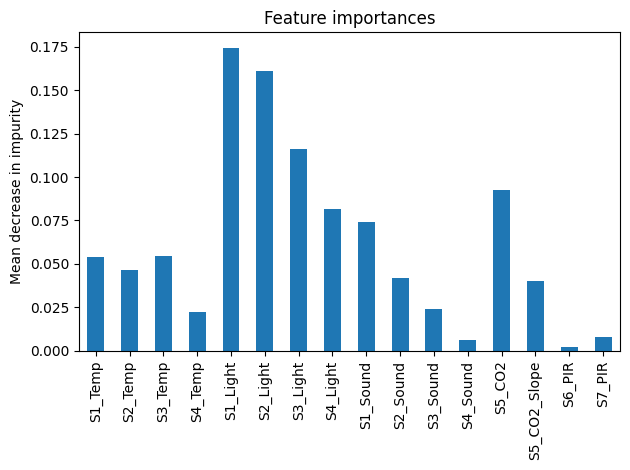

In [ ]:
importances = rf.feature_importances_
importances = pd.Series(importances, index=df_min_max_scaled.columns.to_list())

fig, ax = plt.subplots()
importances.plot.bar( ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Training MLP

In [ ]:
#Grid search of best hyperparameters
MLP_test = MLPClassifier(max_iter=500)
parameter_grid = {
    'hidden_layer_sizes': [(10,),(20,),(10,10)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(MLP_test, parameter_grid, n_jobs=-1, cv=5, scoring='f1_macro', verbose=2)
clf.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(10,), (20,), (10, 10)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='f1_macro', verbose=2)

In [ ]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.987 (+/-0.004) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.993 (+/-0.003) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'adam'}
0.988 (+/-0.004) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.993 (+/-0.005) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.988 (+/-0.004) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.994 (+/-0.004) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}
0.987 (+/-0.005) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.994 (+/-0.003) for {'activation': 'tanh', '

In [ ]:
#Using best hyperparameters
MLP = MLPClassifier(max_iter=500, activation= 'tanh', alpha= 0.001, hidden_layer_sizes= (10, 10), learning_rate= 'adaptive', solver= 'adam')
f1_scores = cross_val_score(MLP, X_train_smote, y_train_smote, cv=5, scoring='f1_macro')
print(np.mean(f1_scores))
MLP.fit(X_train_smote, y_train_smote)
train_preds = MLP.predict(X_train_smote)
train_accuracy = accuracy_score(y_train_smote, train_preds)
print("Training Accuracy:", train_accuracy)
predictions = MLP.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions, average='macro')
print("Test Accuracy:", accuracy)
print("Test F1:", f1)

0.9938211387562829
Training Accuracy: 0.9966871363930188
Test Accuracy: 0.9936833793920252
Test F1: 0.980299642894333


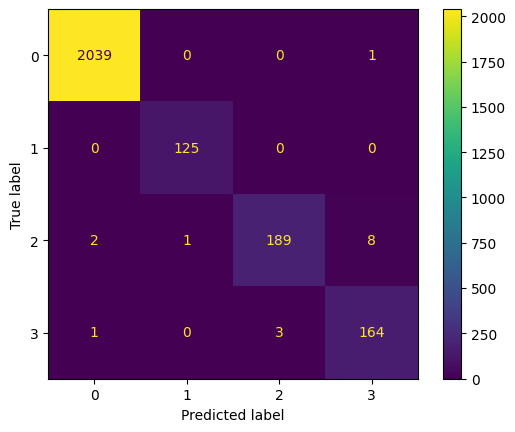

In [ ]:
cm = confusion_matrix(test_labels, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2040
           1       0.99      1.00      1.00       125
           2       0.98      0.94      0.96       200
           3       0.95      0.98      0.96       168

    accuracy                           0.99      2533
   macro avg       0.98      0.98      0.98      2533
weighted avg       0.99      0.99      0.99      2533



## Training SVM

In [ ]:
#Grid search SVM parameters
SVM_test = svm.SVC()
parameter_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid'],} 

clf = GridSearchCV(SVM_test, parameter_grid, n_jobs=-1, cv=5, scoring='f1_macro', verbose=2)
clf.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid']})

In [ ]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'C': 1000, 'gamma': 1, 'kernel': 'poly'}


In [ ]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.987 (+/-0.004) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.994 (+/-0.002) for {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.081 (+/-0.032) for {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.959 (+/-0.004) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.919 (+/-0.005) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.935 (+/-0.006) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.886 (+/-0.017) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.291 (+/-0.090) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.839 (+/-0.018) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.669 (+/-0.062) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.291 (+/-0.090) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.455 (+/-0.125) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.343 (+/-0.172) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.291 (+/-0.090) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
0.343 (+/-0.172) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.990 (+/-0.003) f

In [ ]:
#Using best hyperparameters
SVM = svm.SVC(C= 1000, gamma= 1, kernel= 'poly')
f1_scores = cross_val_score(SVM, X_train_smote, y_train_smote, cv=5, scoring='f1_macro')
print(np.mean(f1_scores))
SVM.fit(X_train_smote, y_train_smote)
train_preds = SVM.predict(X_train_smote)
train_accuracy = accuracy_score(y_train_smote, train_preds)
print("Training Accuracy:", train_accuracy)
predictions = SVM.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions, average='macro')
print("Test Accuracy:", accuracy)
print("Test F1:", f1)

0.9997171877782106
Training Accuracy: 1.0
Test Accuracy: 0.9944729569680221
Test F1: 0.9823182529949721


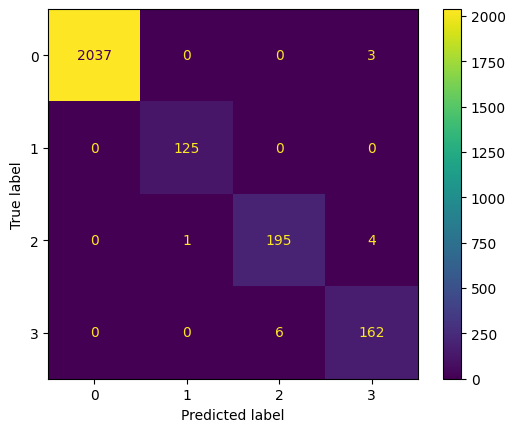

In [ ]:
cm = confusion_matrix(test_labels, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2040
           1       0.99      1.00      1.00       125
           2       0.97      0.97      0.97       200
           3       0.96      0.96      0.96       168

    accuracy                           0.99      2533
   macro avg       0.98      0.98      0.98      2533
weighted avg       0.99      0.99      0.99      2533

